# Experiments in Modeling Issue Segmentation

## Load Libraries and Datasets

In [1]:
import os
import re
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
from rich.table import Table
import numpy as np
from scipy.fft import fft
import scipy.stats as stats
from scipy.signal import find_peaks
from minineedle import needle, core
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
console = Console()
import sys

sys.path.append("..")
from segmentation_scripts.utils import read_csv_file, get_data_directory_path

In [2]:
def generate_table(df, table_title):
    # Create a Rich Table
    table = Table(title=table_title)
    columns = df.columns
    for column in columns:
        table.add_column(column.replace("_", " ").capitalize(), justify="center", style="cyan", no_wrap=True)    

    # Add rows to the table
    for _, row in df.iterrows():
        table.add_row(*[str(value) if pd.notna(value) else "" for value in row])

    # Print the table
    console.print(table)

In [3]:
def filter_integers(token: str) -> bool:
	"""Check if the token is an integer."""
	return bool(re.match(r'^\d+$', token))

def calculate_digit_coverage(rows):
    """Calculate the number of digits in the given rows."""
    number_of_digits = rows['implied_zero'].notna().sum()
    return number_of_digits

def clean_digits(df: pd.DataFrame) -> pd.DataFrame:
	"""Clean and filter digit tokens in the DataFrame while retaining non-digit pages."""
	max_possible_number = df.page_number.max()
	
	df['token'] = df['token'].astype(str)
	if 'volume_name' in df.columns:
		df['volume_number'] = df['volume_number'].fillna(0)
	
	# Identify pages with digit tokens
	subset_digits = df[df['token'].str.isdigit()].copy()
	possible_pages = subset_digits[subset_digits['token'].apply(filter_integers)].copy()
	# Use the smaller subset if possible_pages is smaller
	console.print(f"Number of possible pages {len(possible_pages)} vs subset_digits {len(subset_digits)}")
	if len(possible_pages) < len(subset_digits):
		subset_digits = possible_pages

	# Identify pages without digit tokens
	non_digits_pages = df[(~df['token'].str.isdigit()) & (~df.page_number.isin(subset_digits.page_number))].copy()
	
	# just take the first page of non_digits_pages
	non_digits_pages = non_digits_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume: {len(subset_digits)}")
	console.print(f"Number of non-digit pages in this volume: {len(non_digits_pages)}")
	
	subset_digits['number'] = subset_digits['token'].astype(int, errors='ignore')
	# max_possible_number = max_page + 25
	filtered_subset_digits = subset_digits[(subset_digits['number'] < max_possible_number) & (subset_digits['number'] <= subset_digits.page_number)].copy()
	non_filtered_subset_digits = subset_digits[(subset_digits['number'] >= max_possible_number) & (~subset_digits.page_number.isin(filtered_subset_digits.page_number))].groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume after filtering for max page length: {len(filtered_subset_digits)}")
	console.print(f"Number of pages without digits in this volume after filtering for max page length: {len(non_filtered_subset_digits)}")
	
	# Calculate implied zero only for digit pages
	filtered_subset_digits['implied_zero'] = filtered_subset_digits['page_number'].astype(int) - filtered_subset_digits['number']
	
	final_subset_digits = filtered_subset_digits[filtered_subset_digits['implied_zero'] >= 0]
	console.print(f"Number of digits in this volume after filtering for max page length and implied zero: {len(final_subset_digits)}")
	remaining_missing_pages = df[(~df.page_number.isin(final_subset_digits.page_number)) & (~df.page_number.isin(non_digits_pages.page_number))].copy()
	remaining_missing_pages = remaining_missing_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of pages without digits in this volume after filtering for max page length and digit pages: {len(remaining_missing_pages)}")
	
	# Merge non-digit pages back into the DataFrame
	non_digits_pages['page_type'] = 'non_digit'
	remaining_missing_pages['page_type'] = 'negative_na_digit'
	final_subset_digits['page_type'] = 'digit'
	non_filtered_subset_digits['page_type'] = 'digit_too_large'
	full_df_with_digits = pd.concat([final_subset_digits, non_digits_pages, remaining_missing_pages, non_filtered_subset_digits]).sort_values(by=['page_number']).reset_index(drop=True)
	
	console.print(f"Number of pages after including non-digit pages: {full_df_with_digits.page_number.nunique()}")

	if full_df_with_digits.page_number.nunique() != df.page_number.nunique():
		added_pages = df[~df.page_number.isin(full_df_with_digits.page_number)].copy()
		added_pages = added_pages.groupby('page_number').first().reset_index()
		added_pages['page_type'] = 'added'
		full_df_with_digits = pd.concat([full_df_with_digits, added_pages]).sort_values(by=['page_number']).reset_index(drop=True)
		console.print(f"Number of pages after including added pages: {full_df_with_digits.page_number.nunique()}")

	# Calculate the number of digits per page
	tqdm.pandas(desc="Calculating digits per page")
	digits_per_page = full_df_with_digits.groupby('page_number').progress_apply(calculate_digit_coverage).reset_index(name='digits_per_page')
	full_df_with_digits = full_df_with_digits.merge(digits_per_page, on='page_number', how='left')
	
	return full_df_with_digits

In [4]:
def process_file(file_path: str, is_preidentified_periodical: bool):
	full_df = read_csv_file(file_path)
	console.print(f"Volume has this many tokens: {len(full_df)}")
	if is_preidentified_periodical:
		console.print(f"Volume has this many issues: {full_df.start_issue.nunique()}")
		console.print(f"Volume has this many pages: {full_df.page_number.nunique()}")
	# Factorize the 'issue_number' column to create 'actual_issue_number'
	full_df = full_df.sort_values(by=['page_number'])

	if is_preidentified_periodical:
		full_df = full_df.rename(columns={'issue_number': 'original_issue_number', 'page_number': 'original_page_number'})
		full_df['temp_issue_number'] = pd.factorize(full_df['original_issue_number'])[0]

	else:
		full_df = full_df.rename(columns={'page_number': 'original_page_number'})
	# Factorize the 'original_page_number' column
	factorized_values, unique_values = pd.factorize(full_df['original_page_number'])

	# Adjust the factorized values to start at 1
	full_df['page_number'] = factorized_values + 1
	# Expand count column
	expanded_df = full_df.loc[full_df.index.repeat(full_df['count'])].reset_index(drop=True)
	console.print(f"Expanded volume has this many tokens: {len(expanded_df)}")

	# Calculate the number of tokens per page
	tokens_per_page = expanded_df.groupby('page_number').size().reset_index(name='tokens_per_page')

	# Merge the token counts back into the original DataFrame
	expanded_df = expanded_df.merge(tokens_per_page, on='page_number', how='left')
	missing_pages = full_df[~full_df.page_number.isin(expanded_df.page_number.unique())]
	expanded_df = pd.concat([expanded_df, missing_pages], ignore_index=True)
	expanded_df = expanded_df.reset_index(drop=True)

	if is_preidentified_periodical:
		annotated_df = full_df[['page_number', 'start_issue', 'end_issue', 'type_of_page']].drop_duplicates()

		# Group by 'start_issue' and aggregate
		grouped_df = annotated_df.groupby('start_issue').agg(
			first_page=('page_number', 'min'),
			last_page=('page_number', 'max'),
			number_of_pages=('page_number', 'count')
		).reset_index()
		grouped_df = grouped_df.sort_values(by='first_page')

		generate_table(grouped_df, "Grouped by 'start_issue'")
	else:
		grouped_df = pd.DataFrame()

	# Example usage
	subset_digits = clean_digits(expanded_df)
	subset_digits = subset_digits.sort_values(by=['page_number'])

	if is_preidentified_periodical:
		counts_per_annotated_issue = subset_digits.start_issue.value_counts().reset_index()

		generate_table(counts_per_annotated_issue, "Counts per Annotated Issue")
	return expanded_df, subset_digits, grouped_df

	

In [6]:
# Count the number of matching files
matching_files = []
for directory, _, files in tqdm(os.walk("../datasets/annotated_ht_ef_datasets/"), desc="Counting matching files"):
	for file in files:
		if file.endswith(".csv") and 'individual' in file:
			if os.path.exists(os.path.join(directory, file)):
				matching_files.append({"file": file, "directory": directory, "file_path": os.path.join(directory, file)})
matching_files_df = pd.DataFrame(matching_files)
console.print(f"Found {len(matching_files_df)} matching files.", style="bright_green")

Counting matching files: 95it [00:00, 42753.10it/s]


Found 85 matching files.

In [7]:
file_path = matching_files_df['file_path'][0]
preidentified_periodical = True

In [8]:

expanded_df, subset_digits, grouped_df = process_file(file_path, is_preidentified_periodical=preidentified_periodical)
subset_expanded_df = expanded_df[['page_number', 'tokens_per_page', 'original_page_number', 'htid', 'title', 'pub_date', 'enumeration_chronology',
	'type_of_resource', 'title', 'date_created', 'pub_date', 'language',
	'access_profile', 'isbn', 'issn', 'lccn', 'oclc', 'page_count',
	'feature_schema_version', 'access_rights', 'alternate_title',
	'category', 'genre_ld', 'genre', 'contributor_ld', 'contributor',
	'handle_url', 'source_institution_ld', 'source_institution', 'lcc',
	'type', 'is_part_of', 'last_rights_update_date', 'pub_place_ld',
	'pub_place', 'main_entity_of_page', 'publisher_ld', 'publisher',
	'lowercase_periodical_name', 'publication_directory',
	'volume_directory', 'record_url', 'periodical_name',]].drop_duplicates()

min_subset_digits = subset_digits[['original_page_number',
	'digits_per_page', 'page_number']].drop_duplicates()

merged_expanded_df = subset_expanded_df.merge(min_subset_digits, on=['original_page_number', 'page_number'], how='left')
merged_expanded_df['tokens_per_page'] = merged_expanded_df['tokens_per_page'].fillna(0)
merged_expanded_df['digits_per_page'] = merged_expanded_df['digits_per_page'].fillna(0)
merged_expanded_df['smoothed_tokens_per_page'] = merged_expanded_df['tokens_per_page'].rolling(window=5, center=True).mean()
merged_expanded_df['smoothed_digits_per_page'] = merged_expanded_df['digits_per_page'].rolling(window=5, center=True).mean()

# Scale the tokens per page and digits per page
scaler = MinMaxScaler()

merged_expanded_df['scaled_tokens_per_page'] = scaler.fit_transform(merged_expanded_df[['smoothed_tokens_per_page']])
merged_expanded_df['scaled_digits_per_page'] = scaler.fit_transform(merged_expanded_df[['smoothed_digits_per_page']])

merged_expanded_df['scaled_tokens_per_page'] = merged_expanded_df['scaled_tokens_per_page'].fillna(0)
merged_expanded_df['scaled_digits_per_page'] = merged_expanded_df['scaled_digits_per_page'].fillna(0)


console.print(merged_expanded_df[['page_number', 'tokens_per_page', 'smoothed_tokens_per_page', 'scaled_tokens_per_page', 'digits_per_page', 'smoothed_digits_per_page', 'scaled_digits_per_page']].head(2))

# Perform FFT
tokens_fft = fft(merged_expanded_df['scaled_tokens_per_page'].dropna().values)
digits_fft = fft(merged_expanded_df['scaled_digits_per_page'].dropna().values)

# Calculate frequencies
frequencies = np.fft.fftfreq(len(tokens_fft))

# Detect peaks
token_peaks, _ = find_peaks(merged_expanded_df['scaled_tokens_per_page'].dropna().values, height=0.5)
digit_peaks, _ = find_peaks(merged_expanded_df['scaled_digits_per_page'].dropna().values, height=0.5)

# Calculate autocorrelation
tokens_autocorr = np.correlate(
	merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
	merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
	mode='full'
)

digits_autocorr = np.correlate(
	merged_expanded_df['scaled_digits_per_page'].dropna().values, 
	merged_expanded_df['scaled_digits_per_page'].dropna().values, 
	mode='full'
)

# Plot
lags = np.arange(-len(tokens_autocorr)//2, len(tokens_autocorr)//2)
# Identify dominant lag from autocorrelation
tokens_autocorr_lag = np.argmax(tokens_autocorr[len(tokens_autocorr)//2 + 1:]) + 1
digits_autocorr_lag = np.argmax(digits_autocorr[len(digits_autocorr)//2 + 1:]) + 1
print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}")
print(f"Likely issue length from digits autocorrelation: {digits_autocorr_lag}")
# Detect likely covers
merged_expanded_df['is_likely_cover'] = (
	(merged_expanded_df['scaled_tokens_per_page'] < 0.2) &  # Low tokens
	(merged_expanded_df['scaled_digits_per_page'] < 0.2)    # Low digits
)

# Aggregate features for embedding
volume_features = {
	'avg_tokens': merged_expanded_df['tokens_per_page'].mean(),
	'avg_digits': merged_expanded_df['digits_per_page'].mean(),
	'dominant_frequency': frequencies[np.argmax(np.abs(tokens_fft[:len(frequencies)//2]))],
	'issue_length': tokens_autocorr_lag,  # Or use digits_autocorr_lag,
	'htid': merged_expanded_df['htid'].unique()[0],
	'periodical_name': merged_expanded_df['periodical_name'].unique()[0],
}

console.print(volume_features)

Volume has this many tokens: 21002

Volume has this many issues: 3

Volume has this many pages: 72

Expanded volume has this many tokens: 41781

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1969-10-01  │     1      │    24     │       24        │
│ 1969-11-01  │     25     │    48     │       24        │
│ 1969-12-01  │     49     │    72     │       24        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 564 vs subset_digits 564

Number of digits in this volume: 564

Number of non-digit pages in this volume: 4

Number of digits in this volume after filtering for max page length: 273

Number of pages without digits in this volume after filtering for max page length: 14

Number of digits in this volume after filtering for max page length and implied zero: 273

Number of pages without digits in this volume after filtering for max page length and digit pages: 14

Number of pages after including non-digit pages: 72

Calculating digits per page: 100%|██████████| 72/72 [00:00<00:00, 16397.34it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1969-12-01  │  118  │
│ 1969-11-01  │  104  │
│ 1969-10-01  │  83   │
└─────────────┴───────┘

page_number  tokens_per_page  smoothed_tokens_per_page  \
0            1             26.0                       NaN   
1            2            271.0                       NaN   

   scaled_tokens_per_page  digits_per_page  smoothed_digits_per_page  \
0                     0.0                0                       NaN   
1                     0.0                4                       NaN   

   scaled_digits_per_page  
0                     0.0  
1                     0.0

Likely issue length from tokens autocorrelation: 1
Likely issue length from digits autocorrelation: 1


{
    'avg_tokens': 580.2916666666666,
    'avg_digits': 3.7916666666666665,
    'dominant_frequency': 0.0,
    'issue_length': 1,
    'htid': 'mdp.39015038717792',
    'periodical_name': 'Liberator'
}

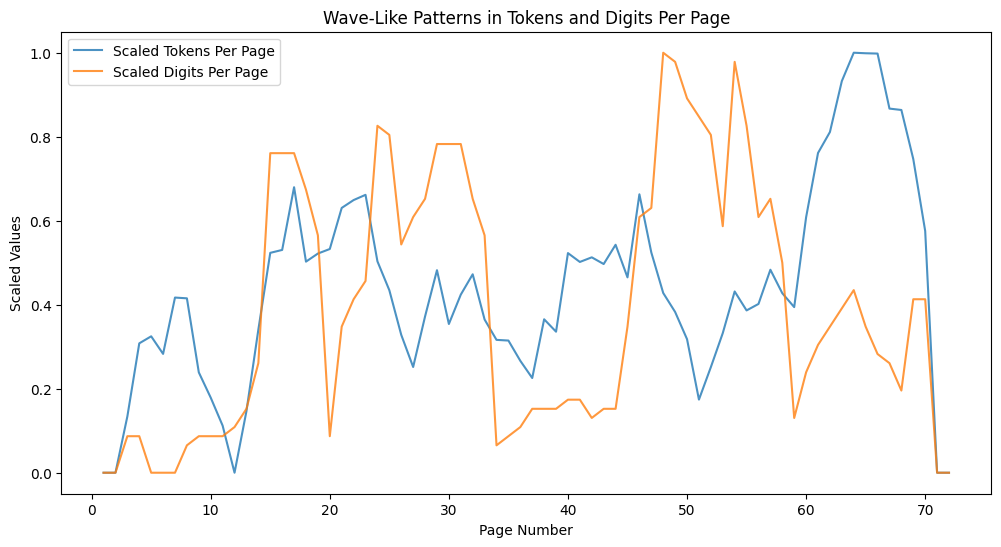

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Tokens per page
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_tokens_per_page'], label='Scaled Tokens Per Page', alpha=0.8)

# Digits per page
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_digits_per_page'], label='Scaled Digits Per Page', alpha=0.8)

plt.title('Wave-Like Patterns in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

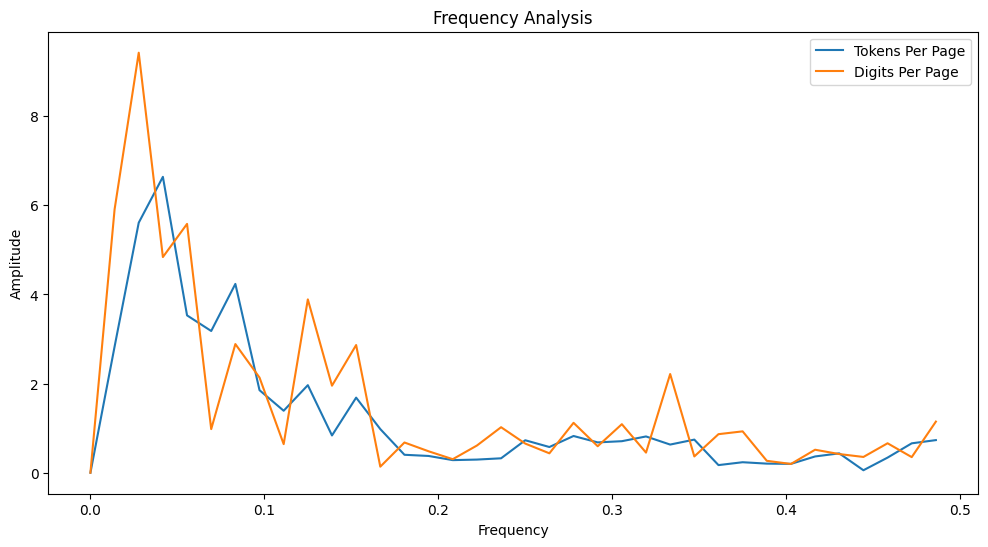

In [10]:
from scipy.fft import fft


tokens_fft_input = merged_expanded_df['scaled_tokens_per_page'].dropna().values
tokens_fft_input -= np.mean(tokens_fft_input)  # Remove DC offset

digits_fft_input = merged_expanded_df['scaled_digits_per_page'].dropna().values
digits_fft_input -= np.mean(digits_fft_input)  # Remove DC offset

tokens_fft = fft(tokens_fft_input)
digits_fft = fft(digits_fft_input)
frequencies = np.fft.fftfreq(len(tokens_fft))

plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(tokens_fft[:len(frequencies)//2]), label='Tokens Per Page')
plt.plot(frequencies[:len(frequencies)//2], np.abs(digits_fft[:len(frequencies)//2]), label='Digits Per Page')
plt.title('Frequency Analysis')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [11]:
# Calculate dominant frequency
print(f"Length of frequencies: {len(frequencies)}")
dominant_frequency_index = np.argmax(np.abs(tokens_fft[1:len(frequencies)//2])) + 1
print(f"Dominant Frequency Index: {dominant_frequency_index}")
dominant_frequency = frequencies[dominant_frequency_index]
print(f"Dominant Frequency: {dominant_frequency}")
# Ensure dominant frequency is positive
if dominant_frequency < 0:
    dominant_frequency = -dominant_frequency

print(f"Dominant Frequency: {dominant_frequency}")
print(merged_expanded_df[['scaled_tokens_per_page', 'scaled_digits_per_page']].describe())

Length of frequencies: 72
Dominant Frequency Index: 3
Dominant Frequency: 0.041666666666666664
Dominant Frequency: 0.041666666666666664
       scaled_tokens_per_page  scaled_digits_per_page
count               72.000000               72.000000
mean                 0.440928                0.394022
std                  0.237435                0.303009
min                  0.000000                0.000000
25%                  0.315917                0.125000
50%                  0.425688                0.347826
75%                  0.531009                0.652174
max                  1.000000                1.000000


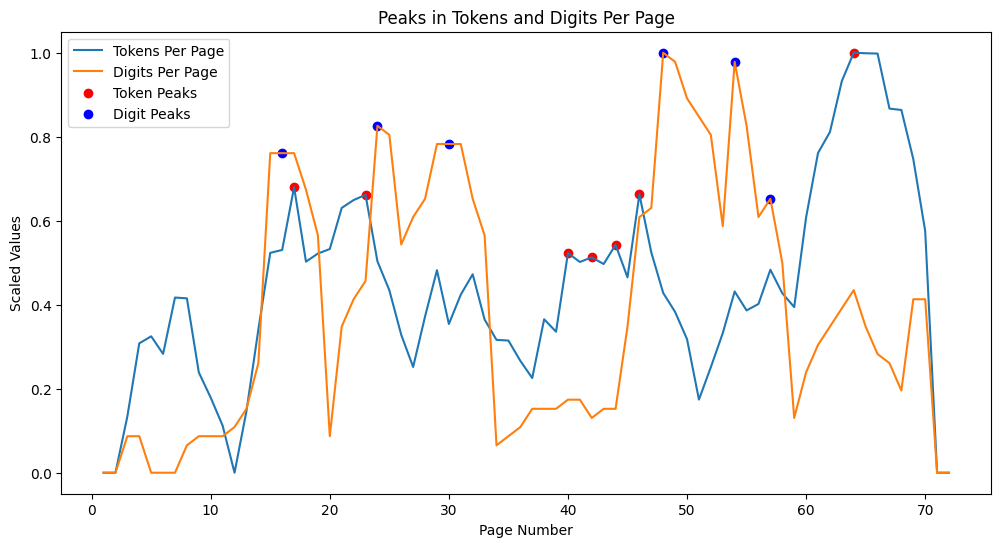

In [12]:
from scipy.signal import find_peaks

# Detect peaks
token_peaks, _ = find_peaks(merged_expanded_df['scaled_tokens_per_page'].dropna().values, height=0.5)
digit_peaks, _ = find_peaks(merged_expanded_df['scaled_digits_per_page'].dropna().values, height=0.5)

# Plot with peaks
plt.figure(figsize=(12, 6))
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_tokens_per_page'], label='Tokens Per Page')
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_digits_per_page'], label='Digits Per Page')
plt.scatter(merged_expanded_df['page_number'].iloc[token_peaks], merged_expanded_df['scaled_tokens_per_page'].iloc[token_peaks], color='red', label='Token Peaks')
plt.scatter(merged_expanded_df['page_number'].iloc[digit_peaks], merged_expanded_df['scaled_digits_per_page'].iloc[digit_peaks], color='blue', label='Digit Peaks')
plt.title('Peaks in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

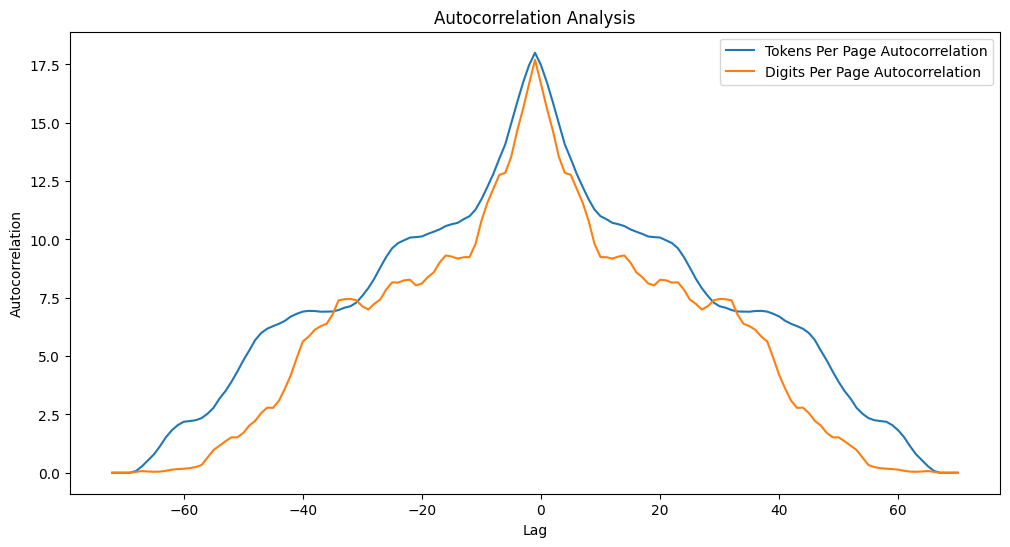

In [13]:
# Calculate autocorrelation
tokens_autocorr = np.correlate(
    merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
    merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
    mode='full'
)

digits_autocorr = np.correlate(
    merged_expanded_df['scaled_digits_per_page'].dropna().values, 
    merged_expanded_df['scaled_digits_per_page'].dropna().values, 
    mode='full'
)

# Plot
lags = np.arange(-len(tokens_autocorr)//2, len(tokens_autocorr)//2)

plt.figure(figsize=(12, 6))
plt.plot(lags, tokens_autocorr, label='Tokens Per Page Autocorrelation')
plt.plot(lags, digits_autocorr, label='Digits Per Page Autocorrelation')
plt.title('Autocorrelation Analysis')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

In [14]:
# Identify dominant lag from autocorrelation
tokens_autocorr_lag = np.argmax(tokens_autocorr[len(tokens_autocorr)//2 + 1:]) + 1
digits_autocorr_lag = np.argmax(digits_autocorr[len(digits_autocorr)//2 + 1:]) + 1
print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}")
print(f"Likely issue length from digits autocorrelation: {digits_autocorr_lag}")

Likely issue length from tokens autocorrelation: 1
Likely issue length from digits autocorrelation: 1


In [15]:
# Detect likely covers
merged_expanded_df['is_likely_cover'] = (
    (merged_expanded_df['scaled_tokens_per_page'] < 0.2) &  # Low tokens
    (merged_expanded_df['scaled_digits_per_page'] < 0.2)    # Low digits
)

In [16]:
# Aggregate features for embedding
volume_features = {
    'avg_tokens': merged_expanded_df['tokens_per_page'].mean(),
    'avg_digits': merged_expanded_df['digits_per_page'].mean(),
    'dominant_frequency': frequencies[np.argmax(np.abs(tokens_fft[:len(frequencies)//2]))],
    'issue_length': tokens_autocorr_lag,  # Or use digits_autocorr_lag,
	'htid': merged_expanded_df['htid'].unique()[0],
	'periodical_name': merged_expanded_df['periodical_name'].unique()[0],
}

console.print(volume_features)

{
    'avg_tokens': 580.2916666666666,
    'avg_digits': 3.7916666666666665,
    'dominant_frequency': 0.041666666666666664,
    'issue_length': 1,
    'htid': 'mdp.39015038717792',
    'periodical_name': 'Liberator'
}

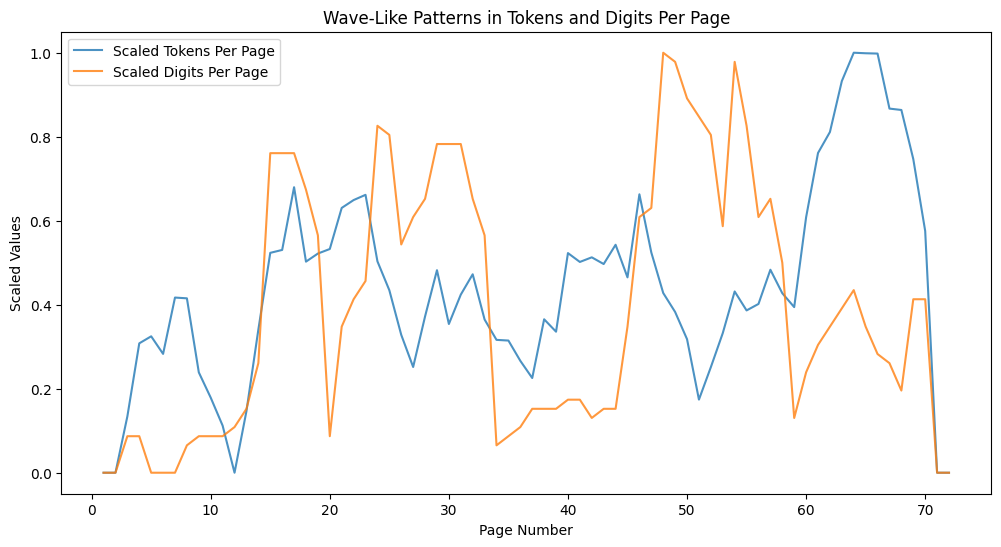

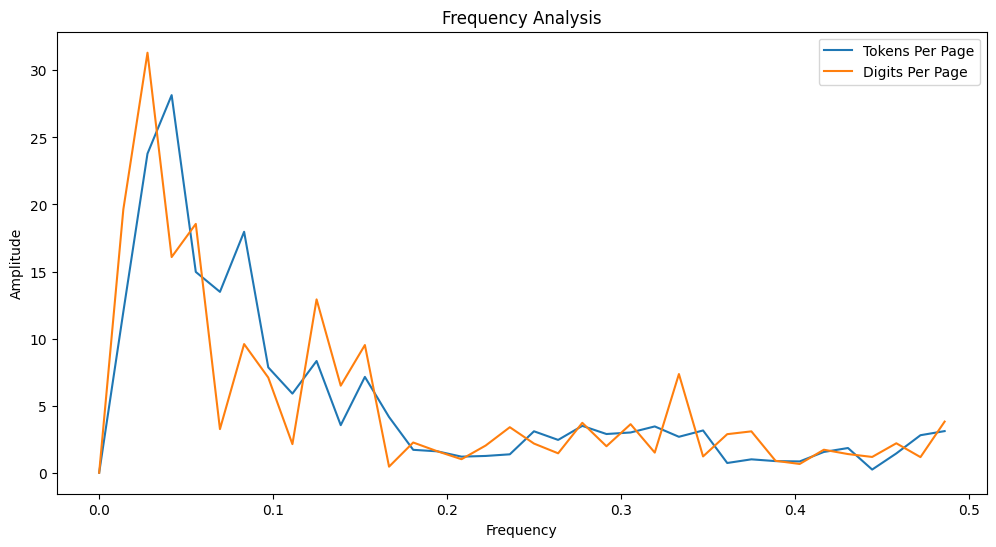

Dominant Frequency: 0.041666666666666664

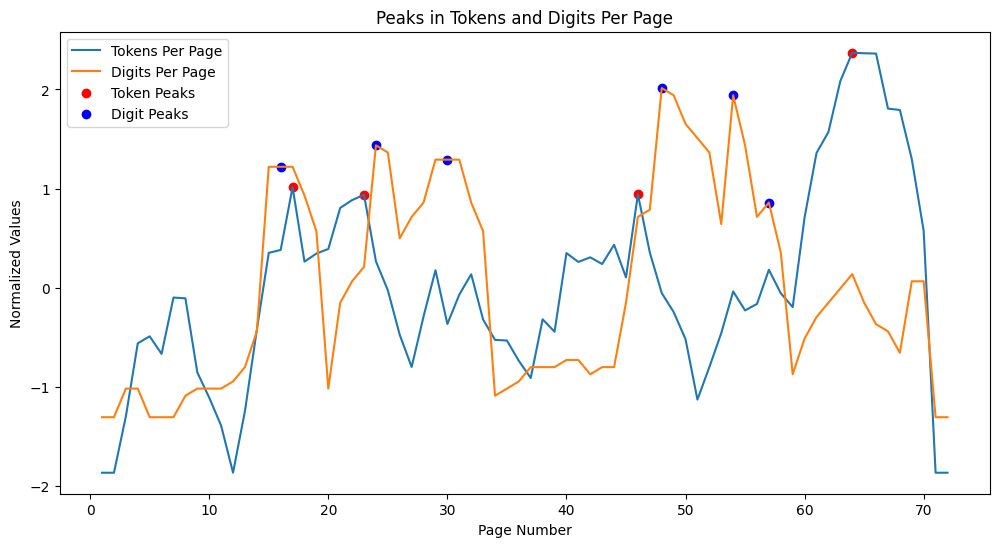

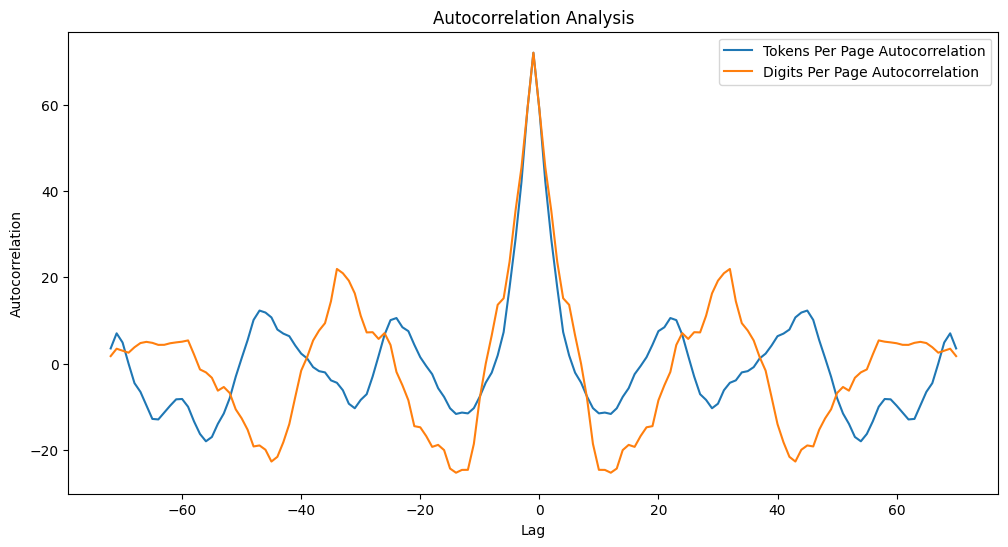

Likely issue length from tokens autocorrelation: 23

Likely issue length from digits autocorrelation: 25

{
    'avg_tokens': 580.2916666666666,
    'avg_digits': 3.7916666666666665,
    'dominant_frequency': 0.041666666666666664,
    'issue_length': 23,
    'htid': 'mdp.39015038717792',
    'periodical_name': 'Liberator'
}

In [17]:
# Plot Tokens and Digits Per Page
plt.figure(figsize=(12, 6))
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_tokens_per_page'], label='Scaled Tokens Per Page', alpha=0.8)
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_digits_per_page'], label='Scaled Digits Per Page', alpha=0.8)
plt.title('Wave-Like Patterns in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

# Normalize signals for FFT and autocorrelation
scaled_tokens = merged_expanded_df['scaled_tokens_per_page'].dropna().values
scaled_digits = merged_expanded_df['scaled_digits_per_page'].dropna().values

tokens_normalized = (scaled_tokens - np.mean(scaled_tokens)) / np.std(scaled_tokens)
digits_normalized = (scaled_digits - np.mean(scaled_digits)) / np.std(scaled_digits)

# Perform FFT
tokens_fft = fft(tokens_normalized)
digits_fft = fft(digits_normalized)
frequencies = np.fft.fftfreq(len(tokens_fft))

# Plot FFT results
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(tokens_fft[:len(frequencies)//2]), label='Tokens Per Page')
plt.plot(frequencies[:len(frequencies)//2], np.abs(digits_fft[:len(frequencies)//2]), label='Digits Per Page')
plt.title('Frequency Analysis')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Calculate dominant frequency
dominant_frequency_index = np.argmax(np.abs(tokens_fft[1:len(frequencies)//2])) + 1
dominant_frequency = frequencies[dominant_frequency_index]
if dominant_frequency < 0:
    dominant_frequency = -dominant_frequency

console.print(f"Dominant Frequency: {dominant_frequency}")

# Detect Peaks in Signal
token_peaks, _ = find_peaks(tokens_normalized, height=0.5)
digit_peaks, _ = find_peaks(digits_normalized, height=0.5)

# Plot Peaks
plt.figure(figsize=(12, 6))
plt.plot(merged_expanded_df['page_number'], tokens_normalized, label='Tokens Per Page')
plt.plot(merged_expanded_df['page_number'], digits_normalized, label='Digits Per Page')
plt.scatter(merged_expanded_df['page_number'].iloc[token_peaks], tokens_normalized[token_peaks], color='red', label='Token Peaks')
plt.scatter(merged_expanded_df['page_number'].iloc[digit_peaks], digits_normalized[digit_peaks], color='blue', label='Digit Peaks')
plt.title('Peaks in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()

# Calculate Autocorrelation
tokens_autocorr = np.correlate(tokens_normalized, tokens_normalized, mode='full')
digits_autocorr = np.correlate(digits_normalized, digits_normalized, mode='full')

# Plot Autocorrelation
lags = np.arange(-len(tokens_autocorr)//2, len(tokens_autocorr)//2)
plt.figure(figsize=(12, 6))
plt.plot(lags, tokens_autocorr, label='Tokens Per Page Autocorrelation')
plt.plot(lags, digits_autocorr, label='Digits Per Page Autocorrelation')
plt.title('Autocorrelation Analysis')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

# Identify Dominant Lag (Issue Length)
from scipy.signal import find_peaks

# Use find_peaks to locate all significant peaks
tokens_peaks, _ = find_peaks(tokens_autocorr[len(tokens_autocorr)//2 + 1:], height=0.1)  # Skip lag 0
digits_peaks, _ = find_peaks(digits_autocorr[len(digits_autocorr)//2 + 1:], height=0.1)  # Skip lag 0

tokens_peak_lags = tokens_peaks + 1  # Adjust for indexing
digits_peak_lags = digits_peaks + 1  # Adjust for indexing

if len(tokens_peak_lags) > 0:
    tokens_autocorr_lag = tokens_peak_lags[0]  # Use first peak as dominant lag
else:
    tokens_autocorr_lag = 1  # Default to 1 if no peaks are found

if len(digits_peak_lags) > 0:
    digits_autocorr_lag = digits_peak_lags[0]  # Use first peak as dominant lag
else:
    digits_autocorr_lag = 1  # Default to 1 if no peaks are found

console.print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}")
console.print(f"Likely issue length from digits autocorrelation: {digits_autocorr_lag}")

# Detect Likely Covers
merged_expanded_df['is_likely_cover'] = (
    (merged_expanded_df['scaled_tokens_per_page'] < 0.2) &  # Low tokens
    (merged_expanded_df['scaled_digits_per_page'] < 0.2)    # Low digits
)

# Aggregate Features for Embedding
volume_features = {
    'avg_tokens': merged_expanded_df['tokens_per_page'].mean(),
    'avg_digits': merged_expanded_df['digits_per_page'].mean(),
    'dominant_frequency': dominant_frequency,
    'issue_length': tokens_autocorr_lag,  # Use the token-based autocorrelation lag
    'htid': merged_expanded_df['htid'].unique()[0],
    'periodical_name': merged_expanded_df['periodical_name'].unique()[0],
}

console.print(volume_features)

In [34]:
volume_features_df = pd.read_csv("../datasets/volume_features_and_frequencies.csv")

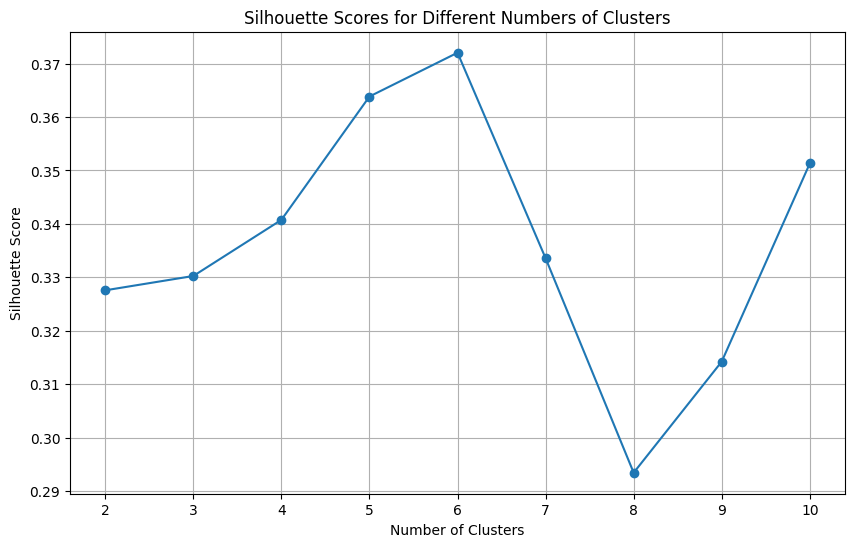

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt

def pca_tsne_kmeans_visualization(volume_features_csv, max_clusters=10):
    # Load volume features
    volume_features_df = pd.read_csv(volume_features_csv)

    # Select numerical features for PCA, t-SNE, and clustering
    numerical_features = [
        'tokens_dominant_frequency', 'digits_dominant_frequency',
        'avg_tokens', 'avg_digits', 'total_pages', 'total_tokens',
        'total_digits', 'tokens_dynamic_cutoff', 'digits_dynamic_cutoff',
        'consensus_issue_length'
    ]
    
    feature_data = volume_features_df[numerical_features].fillna(0)  # Fill missing values with 0

    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_data)

    # Perform PCA
    pca = PCA(n_components=2)  # Reduce to 2D for visualization
    pca_result = pca.fit_transform(normalized_features)

    # Add PCA results to the DataFrame
    volume_features_df['PCA1'] = pca_result[:, 0]
    volume_features_df['PCA2'] = pca_result[:, 1]

    # Perform t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Adjust perplexity as needed
    tsne_result = tsne.fit_transform(normalized_features)

    # Add t-SNE results to the DataFrame
    volume_features_df['t-SNE1'] = tsne_result[:, 0]
    volume_features_df['t-SNE2'] = tsne_result[:, 1]

    # KMeans Clustering with Silhouette Analysis
    silhouette_scores = []
    cluster_labels = None
    optimal_clusters = 0
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(normalized_features)
        silhouette_avg = silhouette_score(normalized_features, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        if silhouette_avg == max(silhouette_scores):
            optimal_clusters = n_clusters
            optimal_labels = cluster_labels  # Save the labels for the best clustering

    # Add the optimal cluster labels to the DataFrame
    volume_features_df['cluster'] = optimal_labels

    # Plot Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # PCA Visualization with Clusters
    pca_chart = alt.Chart(volume_features_df).mark_circle(size=60).encode(
        x='PCA1',
        y='PCA2',
        color=alt.Color('cluster:N', legend=alt.Legend(title="Cluster"), scale=alt.Scale(scheme='viridis')),
        tooltip=['lowercase_periodical_name', 'htid', 'cluster'] + numerical_features
    ).properties(
        title='PCA Visualization with Clusters'
    )

    # t-SNE Visualization with Clusters
    tsne_chart = alt.Chart(volume_features_df).mark_circle(size=60).encode(
        x='t-SNE1',
        y='t-SNE2',
        color=alt.Color('cluster:N', legend=alt.Legend(title="Cluster"), scale=alt.Scale(scheme='viridis')),
        tooltip=['lowercase_periodical_name', 'htid', 'cluster'] + numerical_features
    ).properties(
        title='t-SNE Visualization with Clusters'
    )

    return volume_features_df, pca_chart, tsne_chart

# Run the function
volume_features_df, pca_chart, tsne_chart = pca_tsne_kmeans_visualization("../datasets/volume_features_and_frequencies.csv")


In [48]:
pca_chart

alt.Chart(...)

In [49]:
tsne_chart

alt.Chart(...)

In [50]:
volume_features_df.groupby(['cluster', 'lowercase_periodical_name']).size()

cluster  lowercase_periodical_name   
0        afro-asian_world_affairs         1
         afro_asian_and_world_affairs     1
         solidarity_aapso                 1
         tricontinental                   1
1        arab_observer_and_the_scribe    18
         liberator                        2
2        arab_observer_and_the_scribe     1
         lotus                           25
         tricontinental                  11
3        lotus                            2
4        afro-asian_bulletin              2
         afro-asian_peoples               1
         arab_observer_and_the_scribe     2
         liberator                        1
5        afro-asian_bulletin              7
         afro-asian_peoples               1
         afro-asian_world_affairs         2
         afro_asian_and_world_affairs     2
         arab_observer_and_the_scribe     2
         liberator                        3
         solidarity_aapso                 1
dtype: int64